# Sparkify User Churn Prediction - Spark

This project intends to use Sparkify user data to identify at-risk users who will likely churn. A **small subset(128MB)** of the **full data (12GB)** is used for initial analysis, feature engineering and model development. Once the features and models are selected, the script can be deployed to Spark to build the model on the full dataset.

### Import libraries from PySpark

In [2]:
# Please run below if you haven't import "pyspark" module on local environment:
# !pip install pyspark

# Spark SQL
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import (avg, col, concat, desc, lit, min, max, 
                                    split, udf, countDistinct, sum, count,
                                        isnan, when, sort_array, asc)
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, DoubleType

# Spark ML
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, LinearSVC, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Python
import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Create a Spark session

In [3]:
# Download java first# Create a SparkSession with the application name "sparkify".
# SparkSession is the entry point for interacting with the Spark cluster.
# It requires Java Runtime Environment (JRE) to run, as Spark is built using Scala and Java.
spark = SparkSession \
.builder \
.appName("sparkify") \
.getOrCreate() 

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/14 19:46:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Load raw data

In [4]:
df = spark.read.json('/Users/tinglu/Desktop/spark/sparkify/data/mini_sparkify_event_data.json')

In [5]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
print('Total activity records:', df.count())
print('Total columns:', len(df.columns))

Total activity records: 286500
Total columns: 18


In [7]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Description for each column:
- **Artist**: Composer or artist of the song.
- **Auth**: Login status of the user.
- **firstName**: First name of the user.
- **gender**: Gender of the user.
- **ItemInSession**: Operation sequence number of this session, ordered from small to large based on time.
- **lastName**: Surname or last name of the user.
- **length**: Length of the song in seconds.
- **Level**: Indicates whether the user is a paid user.
- **location**: User's location.
- **method**: HTTP method used to access web pages (e.g., PUT or GET).
- **page**: Type of page or action being performed.
- **registration**: Timestamp representing the user's registration point in time.
- **sessionId**: Session ID used to identify a single login session.
- **song**: Name of the song being played or interacted with.
- **status**: HTTP page return code (e.g., 200, 307, 404).
- **ts**: Timestamp of the log entry.
- **UserAgent**: Information about the client's browser or user agent.
- **UserId**: Unique identifier for the user.




In [8]:
# Summarize `auth` (Login status of the user)
df.groupby('auth').agg(F.countDistinct('userId')).show()

+----------+-------------+
|      auth|count(userId)|
+----------+-------------+
|Logged Out|            1|
| Cancelled|           52|
|     Guest|            1|
| Logged In|          225|
+----------+-------------+



In [9]:
# Filter out Guest and Logged Out to exclude guests
df_clean = df.filter((col('auth') == 'Logged In') | (col('auth') == 'Cancelled'))

In [10]:
# Exclude null user_id
df_clean=df_clean.filter(df['userId']!='')

In [11]:
df_clean.groupby('auth').agg(F.countDistinct('userId')).show()


[Stage 11:>                                                       (0 + 10) / 10]



+---------+-------------+
|     auth|count(userId)|
+---------+-------------+
|Cancelled|           52|
|Logged In|          225|
+---------+-------------+



### Checking missing

In [12]:
# check missing or invalid data
missing_info = []

for column in df_clean.columns:
    missing_count = df_clean.filter(col(column).isNull() | isnan(col(column)) | (col(column) == "")).count()
    total_count = df_clean.count()
    missing_percentage = (missing_count / total_count) * 100
    missing_info.append((column, missing_count, missing_percentage))

print('Missing values count and percentage per column:')
for column, count, percentage in missing_info:
    print(f'Column {column}: Missing Count: {count}, Missing Percentage: {percentage:.2f}%')

Missing values count and percentage per column:
Column artist: Missing Count: 50046, Missing Percentage: 17.99%
Column auth: Missing Count: 0, Missing Percentage: 0.00%
Column firstName: Missing Count: 0, Missing Percentage: 0.00%
Column gender: Missing Count: 0, Missing Percentage: 0.00%
Column itemInSession: Missing Count: 0, Missing Percentage: 0.00%
Column lastName: Missing Count: 0, Missing Percentage: 0.00%
Column length: Missing Count: 50046, Missing Percentage: 17.99%
Column level: Missing Count: 0, Missing Percentage: 0.00%
Column location: Missing Count: 0, Missing Percentage: 0.00%
Column method: Missing Count: 0, Missing Percentage: 0.00%
Column page: Missing Count: 0, Missing Percentage: 0.00%
Column registration: Missing Count: 0, Missing Percentage: 0.00%
Column sessionId: Missing Count: 0, Missing Percentage: 0.00%
Column song: Missing Count: 50046, Missing Percentage: 17.99%
Column status: Missing Count: 0, Missing Percentage: 0.00%
Column ts: Missing Count: 0, Missing

0% missing data (`UserId` and `SessionId`)

Please be aware that the 'artist' and 'songs' columns have more missing values, accounting for about 18% of rows. This is due to the nature of the records, which involve actions such as logging into the service and accessing the homepage.

## Exploratory Data Analysis
### Define Churn - `auth`
Define churn based on the `auth` (Login status of the user). During the data cleaning process, we noticed that the "Cancelled" status is likely related to customer churn. In the small dataset, the overall churn probability is 23%.

In [13]:
# Generate churn 1/0 as binary indicator `cancel` 1/0
cancel = udf(lambda auth: 1 if auth == 'Cancelled' else 0, IntegerType())
df_clean = df_clean.withColumn('cancel', cancel('auth'))

### Investigate user activities -  `page`

Text(0.5, 1.0, 'Page Counts')

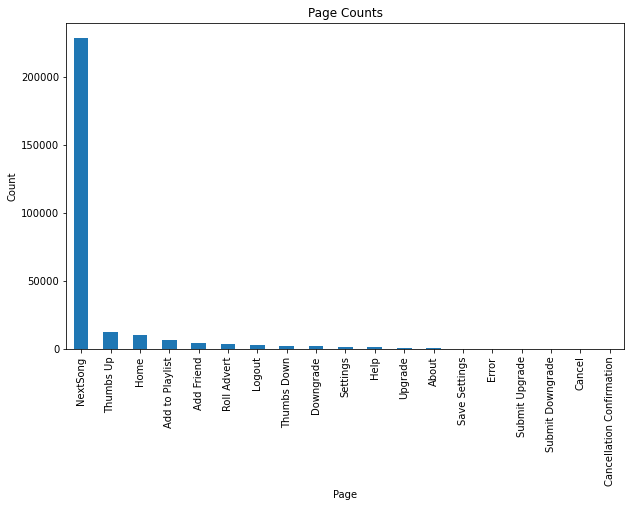

In [14]:
# All user activity types
all_pages = df_clean.select("page").toPandas()

plt.figure(figsize=(10, 6))
all_pages['page'].value_counts().plot(kind='bar')
plt.xlabel('Page')
plt.ylabel('Count')
plt.title('Page Counts')

Some user activities are not initiated by users themselves, making it challenging to represent their preferences or habits. Establishing a relationship with the churn rate for these activities is difficult.

In [15]:
pages = df_clean.groupby('page','method').count().sort('method')
pages.show()

+--------------------+------+------+
|                page|method| count|
+--------------------+------+------+
|               About|   GET|   495|
|            Settings|   GET|  1514|
|                Help|   GET|  1454|
|           Downgrade|   GET|  2055|
|             Upgrade|   GET|   499|
|               Error|   GET|   252|
|Cancellation Conf...|   GET|    52|
|                Home|   GET| 10082|
|         Roll Advert|   GET|  3933|
|          Add Friend|   PUT|  4277|
|              Logout|   PUT|  3226|
|      Submit Upgrade|   PUT|   159|
|     Add to Playlist|   PUT|  6526|
|              Cancel|   PUT|    52|
|    Submit Downgrade|   PUT|    63|
|       Save Settings|   PUT|   310|
|         Thumbs Down|   PUT|  2546|
|            NextSong|   PUT|228108|
|           Thumbs Up|   PUT| 12551|
+--------------------+------+------+



The `page` variable shows the interaction information between the user and the spackify music app, where `NextSong` can be used to calculate the number of songs the user listens to, thumbs up, thumbs down and other behaviors have obvious emotional colors, which are closely related to the user churn rate intuitively.

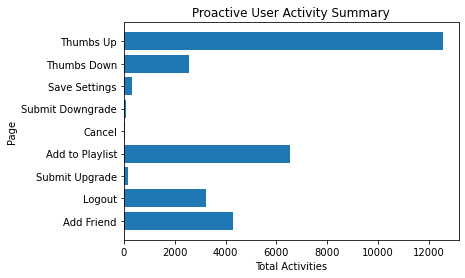

In [16]:
# Use 'PUT' to get user proactive activities
pages_df= pages.toPandas()
pro_pages_df = pages_df.loc[(pages_df['method'] == 'PUT') & (pages_df['page'] != 'NextSong')]

activity = pro_pages_df['page']
count = pro_pages_df['count']

plt.barh(activity, count)
plt.ylabel('Page')
plt.xlabel('Total Activities')
plt.title('Proactive User Activity Summary')
plt.show()

### Investigate how user downgrade (paid to free)

In [17]:
# "Paid to free" happens right after `submit downgrade`
df_clean.filter(col('userId') == '131')\
    .groupby(['userId','level', 'sessionId', 'page'])\
    .agg(min(F.from_unixtime(col('ts')/lit(1000))).alias('timestamp'))\
    .sort(col('timestamp').desc())\
    .show(25)

+------+-----+---------+----------------+-------------------+
|userId|level|sessionId|            page|          timestamp|
+------+-----+---------+----------------+-------------------+
|   131| free|     2281|            Home|2018-11-29 22:21:23|
|   131| free|     2155|      Add Friend|2018-11-24 23:33:37|
|   131| free|     2155|     Thumbs Down|2018-11-24 22:40:05|
|   131| free|     2155|            Home|2018-11-24 22:00:42|
|   131| free|     2155|          Logout|2018-11-24 21:55:35|
|   131| free|     2155|     Roll Advert|2018-11-24 21:48:26|
|   131| free|     2155|       Thumbs Up|2018-11-24 21:09:51|
|   131| free|     2155|           About|2018-11-24 20:53:42|
|   131| free|     2155| Add to Playlist|2018-11-24 20:33:34|
|   131| free|     2155|        NextSong|2018-11-24 20:32:31|
|   131| free|     2094|        NextSong|2018-11-21 06:31:30|
|   131| free|     2094|            Home|2018-11-21 06:31:26|
|   131| free|     2041|     Roll Advert|2018-11-19 19:15:16|
|   131|

### Investigate user location
There are too many categories for the "location" feature, making it challenging to organize. It might be worth considering temporarily dropping this feature.

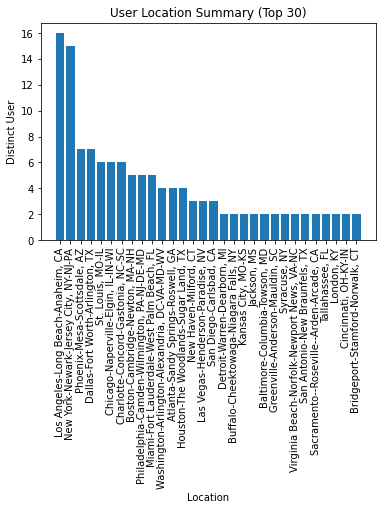

In [18]:
df_loc = df_clean.groupby('location').agg(countDistinct('userId')).toPandas()
df_loc = df_loc.sort_values('count(userId)', ascending = False).iloc[:30,:]

plt.bar(df_loc['location'], df_loc['count(userId)'])
plt.ylabel('Distinct User')
plt.xlabel('Location')
plt.title('User Location Summary (Top 30)')
plt.xticks(rotation='vertical')

plt.show()

### Investigate user activity over time

In [19]:
# Convert ts to date and get user activity summary over time
df_clean = df_clean.withColumn("date", F.to_date(F.from_unixtime(col('ts')/lit(1000))))

time = df_clean.select(['date','sessionId','userId','level','song']\
                      ).groupby(['date','level']).agg(F.count(col('sessionId')), F.countDistinct(col('userId')),\
                                                      F.count(col('song')))
df_time = time.toPandas()
df_time.head()

,date,level,count(sessionId),count(userId),count(song)
0,2018-10-27,free,434,12,344
1,2018-11-25,paid,2449,26,2032
2,2018-10-24,paid,4436,43,3735
3,2018-10-20,paid,4678,31,3912
4,2018-10-20,free,667,15,497


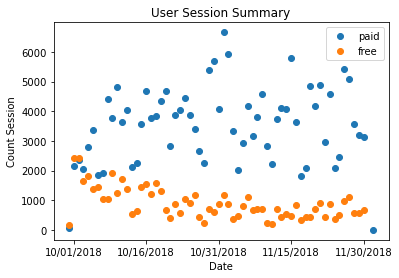

In [20]:
# Count session over time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))

# plot
plt.plot_date(df_time['date'][df_time.level == "paid"], df_time['count(sessionId)'][df_time.level == "paid"], label = 'paid')
plt.plot_date(df_time['date'][df_time.level == "free"], df_time['count(sessionId)'][df_time.level == "free"], label = 'free')
plt.legend()
plt.ylabel('Count Session')
plt.xlabel('Date')
plt.title('User Session Summary')
plt.show()

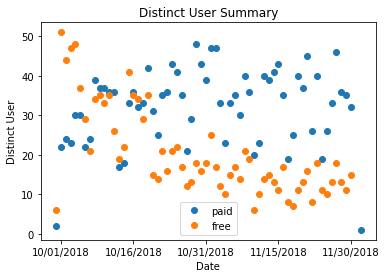

In [21]:
# Count distinct user over time

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))

plt.plot_date(df_time['date'][df_time.level == "paid"], df_time['count(userId)'][df_time.level == "paid"], label = 'paid')
plt.plot_date(df_time['date'][df_time.level == "free"], df_time['count(userId)'][df_time.level == "free"], label = 'free')
plt.ylabel('Distinct User')
plt.xlabel('Date')
plt.title('Distinct User Summary')
plt.legend()
plt.show()

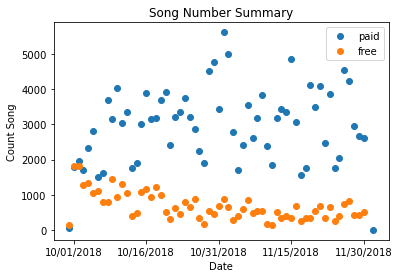

In [22]:
# Count songs over time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))

plt.plot_date(df_time['date'][df_time.level == "paid"], df_time['count(song)'][df_time.level == "paid"], label = 'paid')
plt.plot_date(df_time['date'][df_time.level == "free"], df_time['count(song)'][df_time.level == "free"], label = 'free')
plt.ylabel('Count Song')
plt.xlabel('Date')
plt.title('Song Number Summary')
plt.legend()
plt.show()

The number of free users, free usersessions and free songs decreases over time.

## Feature Engineering

In [23]:
df_feat = df_clean

### User Age

In [24]:
# Calculate user age since registration to the activity date
df_feat = df_feat.withColumn("date", F.to_date(F.from_unixtime(col('ts')/lit(1000))))
df_feat = df_feat.withColumn('date_register', F.to_date(F.from_unixtime(col('registration')/lit(1000))))
df_feat = df_feat.withColumn('user_age', F.datediff(col('date'), col('date_register')))
df_feat.describe('user_age').show()

+-------+------------------+
|summary|          user_age|
+-------+------------------+
|  count|            278154|
|   mean| 64.76562983095695|
| stddev|41.997767963116296|
|    min|                -2|
|    max|               256|
+-------+------------------+



<AxesSubplot:>

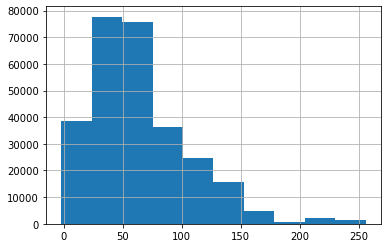

In [25]:
# User age in not churn user
df_cancelled = df_feat.filter(col('cancel') == 0).select(['date','user_age']).toPandas()
df_cancelled['user_age'].hist()


[Stage 156:>                                                      (0 + 10) / 10]



<AxesSubplot:>

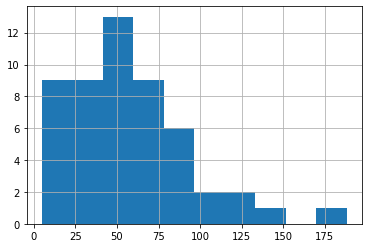

In [26]:
# User age in churn user
df_cancelled = df_feat.filter(col('cancel') == 1).select(['date','user_age']).toPandas()
df_cancelled['user_age'].hist()

### User interaction

In [27]:
# Get proactive user interactions except for playing songs
inter = ['Thumbs Up', 'Thumbs Down', 'Add to Playlist', 'Add Friend']
get_interactions = udf(lambda x: 1 if x in inter else 0, IntegerType())

# Get negative feedback from user
thumbs_down = udf(lambda x: 1 if x == 'Thumbs Down' else 0, IntegerType())

df_feat = df_feat.withColumn('interactions', get_interactions('page'))
df_feat = df_feat.withColumn('thumbs_down', thumbs_down('page'))

In [28]:
# Create `downgrades` to show if the user ever downgraded
downgraded = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
df_feat = df_feat.withColumn('downgraded', downgraded('page'))

In [29]:
# Create `paid` to show if the user ever be 'paid' user
paid = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
df_feat = df_feat.withColumn('paid', paid('level'))

In [30]:
# Create `songs` feature to calculate number of songs from users
NextSong = udf(lambda x: 1 if x == 'NextSong' else 0, IntegerType())
df_feat = df_feat.withColumn('songs', NextSong('page'))

In [31]:
# Convert gender to 1/0. 1 = Female
female = udf(lambda x: 1 if x == 'F' else 0, IntegerType())
df_feat = df_feat.withColumn('female', female('gender'))

### User level dimension

In [32]:
user_dims = df_feat.groupby('userId','female','date_register').agg(\
                                                          max('user_age').alias('user_age'),\
                                                          max('paid').alias('paid_user'),\
                                                          max('downgraded').alias('downgraded_user'),\
                                                          max('cancel').alias('canceled'))

In [33]:
# Inspect Dimensions
user_dims.take(1)

[Row(userId='142', female=0, date_register=datetime.date(2018, 9, 28), user_age=63, paid_user=1, downgraded_user=0, canceled=0)]

### Measures based on usersessions and interactions

In [34]:
# Get the aggregates measures by userId & sessionId level
measures = df_feat.groupby('userId','sessionId').agg(\
                                                      min('date').alias('start_date'),\
                                                      max('date').alias('end_date'),\
                                                      sum('interactions').alias('interactions'),\
                                                      sum('thumbs_down').alias('thumbs_down'),\
                                                      sum('songs').alias('songs'),\
                                                      sum('length').alias('length'),\
                                                      countDistinct('artist').alias('c_artist'))

In [35]:
# Get the date gap between sessions
# Get the aggregates measures by userId level
measures.createOrReplaceTempView("measures_temp")
measures_agg = spark.sql(
"""
    SELECT
        userId AS userId,
        COUNT(sessionId) AS total_session,
        AVG(interactions) AS interactions,
        AVG(thumbs_down) AS thumbs_down,
        AVG(songs) AS songs,
        AVG(length) AS length,
        AVG(c_artist) AS artists,
        AVG(session_gap) AS session_gap
    FROM (
        SELECT
            *,
            LAG(end_date) OVER (PARTITION BY userId ORDER BY start_date) AS prev_end_date,
            DATEDIFF(start_date, LAG(end_date) OVER (PARTITION BY userId ORDER BY start_date)) AS session_gap
        FROM
            measures_temp
    ) AS temp
    GROUP BY userId
""")


23/10/14 19:46:57 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [36]:
# Inspect measures
measures_agg.take(1)

[Row(userId='10', total_session=6, interactions=10.333333333333334, thumbs_down=0.6666666666666666, songs=112.16666666666667, length=27811.062085, artists=104.66666666666667, session_gap=8.0)]

In [37]:
# Inspect user_dim and measure shape
print('user_dims: ', user_dims.count(),' measure_agg: ', measures_agg.count())

user_dims:  225  measure_agg:  225


In [38]:
# Join dims and measures_agg
df_model = user_dims.join(measures_agg, on = 'userId')

In [39]:
# Inspect df_model shape
print(df_model.toPandas().shape)

(225, 14)


In [40]:
df_model_P=df_model.toPandas()

In [41]:
# Inspect NULL value in after-join data
df_model_P.loc[df_model_P.isnull().sum(axis = 1) > 0]

,userId,female,date_register,user_age,paid_user,downgraded_user,canceled,total_session,interactions,thumbs_down,songs,length,artists,session_gap
7,100006,1,2018-09-26,9,0,0,1,1,9.0,2.0,26.0,5854.89105,26.0,NaN
12,100011,0,2018-09-26,5,0,0,1,1,3.0,1.0,11.0,2841.69950,11.0,NaN
18,100017,0,2018-08-02,79,0,0,1,1,4.0,1.0,52.0,12261.72340,51.0,NaN
24,100024,0,2018-09-07,27,0,0,1,1,5.0,0.0,22.0,5160.53207,22.0,NaN
52,125,0,2018-08-01,72,0,0,1,1,0.0,0.0,8.0,2089.11310,8.0,NaN
60,133,0,2018-09-05,39,0,0,0,1,6.0,0.0,32.0,8029.16428,32.0,NaN
62,135,1,2018-07-24,72,0,0,0,1,0.0,0.0,6.0,1596.44461,6.0,NaN
80,151,0,2018-09-25,42,1,0,0,1,10.0,1.0,138.0,32481.13906,132.0,NaN
85,156,0,2018-11-26,0,0,0,0,1,0.0,0.0,3.0,691.66884,3.0,NaN
89,19,1,2018-09-18,22,1,0,0,1,19.0,2.0,216.0,54480.93387,197.0,NaN


All sessions with a missing `session_gap` are associated with a `total session = 1`. This indicates two possible scenarios: 

1. The user is new, having just registered.
2. The user has been dormant since registration.

While the second scenario is highly likely to indicate churn, it is distinct from the churn we are attempting to predict in this context. We are focused on identifying users who were previously active but have now decided to leave our platform. Therefore, we will `exclude` the scenario from our prediction analysis.

array([[<AxesSubplot:title={'center':'female'}>,
        <AxesSubplot:title={'center':'user_age'}>,
        <AxesSubplot:title={'center':'paid_user'}>],
       [<AxesSubplot:title={'center':'downgraded_user'}>,
        <AxesSubplot:title={'center':'canceled'}>,
        <AxesSubplot:title={'center':'total_session'}>],
       [<AxesSubplot:title={'center':'interactions'}>,
        <AxesSubplot:title={'center':'thumbs_down'}>,
        <AxesSubplot:title={'center':'songs'}>],
       [<AxesSubplot:title={'center':'length'}>,
        <AxesSubplot:title={'center':'artists'}>,
        <AxesSubplot:title={'center':'session_gap'}>]], dtype=object)

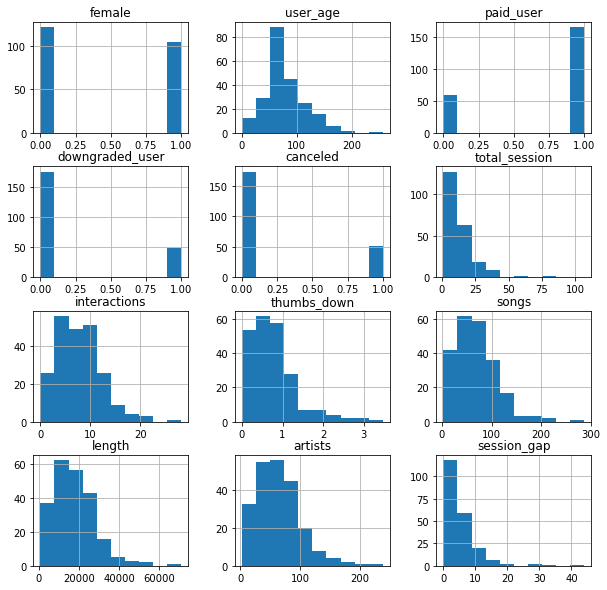

In [42]:
df_model_P.hist(figsize = (10,10))

<AxesSubplot:>

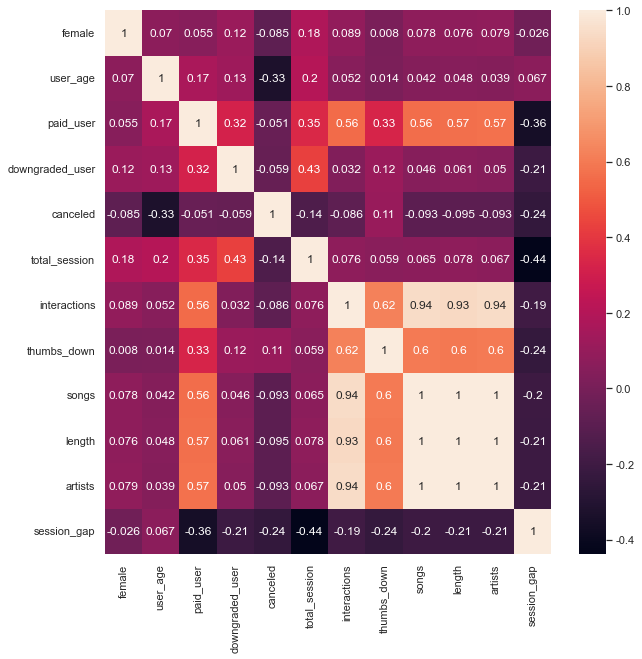

In [43]:
# Get correlations
sns.set(rc={'figure.figsize':(10,10)},font_scale=1)
sns.heatmap(df_model_P.corr(), annot=True)

From histogram and correlation matrix, **songs**, **length** and **artists** are very similar. We will only include **length** in the model as it has higher correlation with **canceled** and other features.

## Modeling

In [44]:
df_model.printSchema()

root
 |-- userId: string (nullable = true)
 |-- female: integer (nullable = true)
 |-- date_register: date (nullable = true)
 |-- user_age: integer (nullable = true)
 |-- paid_user: integer (nullable = true)
 |-- downgraded_user: integer (nullable = true)
 |-- canceled: integer (nullable = true)
 |-- total_session: long (nullable = false)
 |-- interactions: double (nullable = true)
 |-- thumbs_down: double (nullable = true)
 |-- songs: double (nullable = true)
 |-- length: double (nullable = true)
 |-- artists: double (nullable = true)
 |-- session_gap: double (nullable = true)



Exclude Null value, `artists`, `songs`, `userId`, `date_register` (The previous analysis has provided reasons for this decision.)

### ML Pipeline & Function

In [45]:
# Assemble num Features 
assembler = VectorAssembler(inputCols=['female','user_age','paid_user',\
                                       'downgraded_user','total_session', 'interactions',\
                                      'thumbs_down','length','session_gap'],\
                            outputCol='NumFeatures',handleInvalid = 'skip')
data = assembler.transform(df_model)

# Use 'canceled' as model prediction label
data = data.withColumnRenamed('canceled','label')

In [46]:
# Split train/test data
test, validation = data.randomSplit([0.8, 0.2], seed=42)

In [47]:
# Standard Scaler
standardscaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withMean=True, withStd=True)

# ML classification algorithms from Pyspark mllib
lr = LogisticRegression(maxIter=10)
gbt = GBTClassifier(maxIter=5, maxDepth=2)
lsvc = LinearSVC(maxIter=10, regParam=0.1)
rf = RandomForestClassifier()

In [48]:
def fit_model(model, paramGrid = None):
    """
    Input: model, paramgrid (optional)
    Output: fitted model, prediction on validation set
    """
    pipeline = Pipeline(stages=[standardscaler, model])
    
    if paramGrid != None:
        crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
        fitmodel = crossval.fit(test)
    else:
        fitmodel = pipeline.fit(test)
    
    results = fitmodel.transform(validation)
    
    return fitmodel, results

In [49]:
# Evaluate the model on validation set
def val_evaluation(results):
    """
    Input: prediction results
    Output: accuracy, precision and recall score
    """
    predictionAndLabels = results.select(['prediction', 'label']\
                                      ).withColumn('label', col('label').cast(DoubleType())).rdd

    metrics = MulticlassMetrics(predictionAndLabels) # create confusion matrix to calculate evaluation metrics
    cm=metrics.confusionMatrix().toArray() # convert confusion matrix to numpy array
    
    # accuracy: (TP+TN)/Total Predictions
    # precision: TP/(TP + FP)
    # recall: TP/(TP + FN)
    # f1 score: 2*(Recall * Precision) / (Recall + Precision)
    accuracy=(cm[0][0]+cm[1][1])/cm.sum()
    precision=(cm[1][1])/(cm[0][1]+cm[1][1])
    recall=(cm[1][1])/(cm[1][0]+cm[1][1])
    f1 = MulticlassClassificationEvaluator().evaluate(results)

    return(round(f1,2), round(accuracy,2),round(precision,2),round(recall,2))

### Model fit and evaluation

In [50]:
lrmodel, lrresults = fit_model(lr)
rfmodel, rfresults = fit_model(rf)
lsvcmodel, lsvcresults = fit_model(lsvc)
gbtmodel, gbtresults = fit_model(gbt)

23/10/14 19:47:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [51]:
models = ["LogisticRegression", "RandomForest", "Linear SVM", "GBT"]
results = [val_evaluation(lrresults), val_evaluation(rfresults), val_evaluation(lsvcresults), val_evaluation(gbtresults)]
results_df = pd.DataFrame(results, columns=["F1 Score", "Accuracy", "Precision", "Recall"], index=models)
results_df

,F1 Score,Accuracy,Precision,Recall
LogisticRegression,0.82,0.84,1.0,0.38
RandomForest,0.82,0.84,1.0,0.38
Linear SVM,0.71,0.78,1.0,0.12
GBT,0.77,0.81,1.0,0.25


Logistic Regression and Random Forest both have the best performance in all metrics. Since **Random Forest** is more effective in large dataset, it will be trained and tuned with full **12GB** data well.

Linear SVM classifier and Gradient Boosting Classifier have very low recall which means they are less likely to identify any churn user.

## Logistic Regression Tuning
- Look the coefficients
- Find the best threshold
- Apply weights to unbalanced data

In [52]:
# Get current training summary
trainingSummary = lrmodel.stages[-1].summary

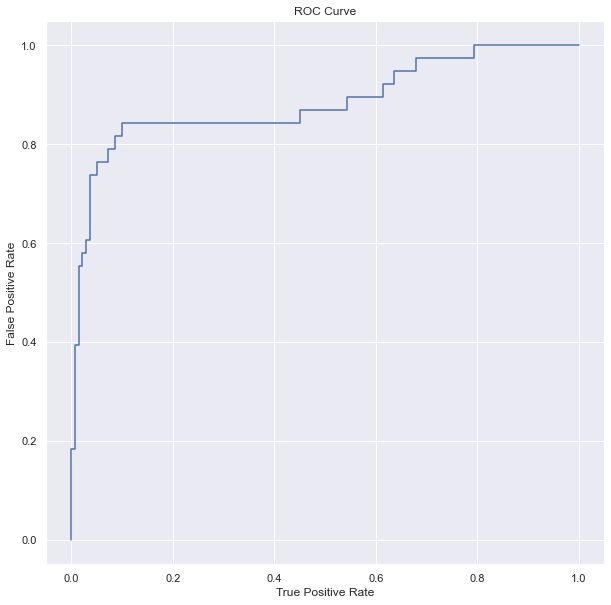

Training set areaUnderROC: 0.88


In [53]:
# AUC-ROC in LR
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(round(trainingSummary.areaUnderROC,2)))

In [54]:
# Extract feature names from the original data
dict_feats = data.schema['NumFeatures'].metadata['ml_attr']['attrs']['numeric']
list_feats = np.array([x['name'] for x in dict_feats])

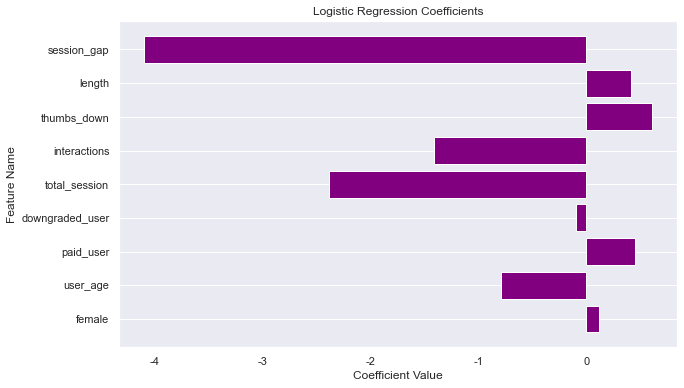

In [55]:
# Get LR coefficients
lr_corr = lrmodel.stages[-1].coefficients

plt.figure(figsize=(10, 6))
plt.barh(list_feats, lr_corr, color = 'purple')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Logistic Regression Coefficients')
plt.grid(axis='x')
plt.show()

### Best Threshold in LR

In [56]:
# Get best threshold for current lr model
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()

bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']

print('bestThreshold in current LR model:', round(bestThreshold,2))

bestThreshold in current LR model: 0.47


### LR model - Add Weight

In [57]:
# Try weighted col since the cancelled outcome is unbalanced (20%)
balancingRatio = data.filter(col('label') == 1).count() / data.count()
calculateWeights = udf(lambda x: 1 * balancingRatio if x == 0 else (1 * (1.0 - balancingRatio)), DoubleType())

weightedDataset = data.withColumn("classWeightCol", calculateWeights('label'))

In [58]:
weightedDataset.groupby('classWeightCol').count().show()

+-------------------+-----+
|     classWeightCol|count|
+-------------------+-----+
|0.21904761904761905|  164|
|  0.780952380952381|   46|
+-------------------+-----+



In [59]:
test, validation = weightedDataset.randomSplit([0.8, 0.2], seed=42)

lrweightedmodel, lrweightedresults = fit_model(lr.setWeightCol('classWeightCol'))
models = ["LogisticRegression", "LogisticRegression with weight"]
results = [val_evaluation(lrresults), val_evaluation(lrweightedresults)]
results_df = pd.DataFrame(results, columns=["F1 Score", "Accuracy", "Precision", "Recall"], index=models)
results_df

,F1 Score,Accuracy,Precision,Recall
LogisticRegression,0.82,0.84,1.00,0.38
LogisticRegression with weight,0.81,0.81,0.62,0.62


In the logistic regression model with weights, the **recall** is significantly higher at **0.62** compared to the original logistic regression model at 0.38, despite a decrease in precision. In a churn prediction task, it is more crucial to identify all at-risk churn users, making recall more important.

## Random Forest Tuning
- Look feature importance
- Conduct **grid search** to explore the best parameter configuration and apply in full 12GB data

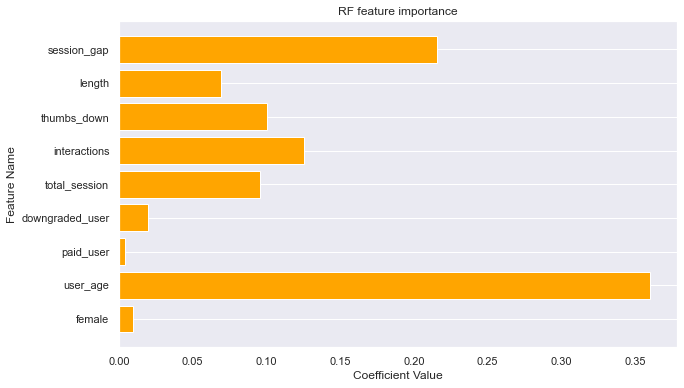

In [60]:
# Extract feature importance from rfmodel
featImportances = np.array(rfmodel.stages[-1].featureImportances)
plt.figure(figsize=(10, 6))
plt.barh(list_feats, featImportances, color = 'orange')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('RF feature importance')
plt.grid(axis='x')
plt.show()

### Gird search in RF

In [61]:
param_grid = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [5, 10])\
    .addGrid(rf.numTrees, [20, 30])\
    .build()


In [62]:
rfbest, rfresults = fit_model(rf, paramGrid = param_grid)

In [63]:
# print best model params
bp_index = rfbest.avgMetrics.index(np.max(rfbest.avgMetrics))
bp = param_grid[bp_index]
print(bp)

{Param(parent='RandomForestClassifier_9680f4f9bcc0', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 10, Param(parent='RandomForestClassifier_9680f4f9bcc0', name='numTrees', doc='Number of trees to train (>= 1).'): 20}


In [64]:
print("RandomForest: f1, accuracy,precision,recall", val_evaluation(rfresults))

RandomForest: f1, accuracy,precision,recall (0.77, 0.81, 1.0, 0.25)


In [65]:
# Extract feature importance from rfmodel
featImportances = np.array(rfbest.bestModel.stages[-1].featureImportances)

In [66]:
print(list_feats,featImportances)

['female' 'user_age' 'paid_user' 'downgraded_user' 'total_session'
 'interactions' 'thumbs_down' 'length' 'session_gap'] [0.01926786 0.29212907 0.00677125 0.01678088 0.12918773 0.1239985
 0.12501523 0.08479692 0.20205256]
